for colab

In [1]:
!pip install equinox jaxtyping

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from functools import partial
import math
import os
from typing import Callable

import tqdm

import numpy as np

import jax
import jax.numpy as jnp

import equinox as eqx

import optax

from jaxtyping import PyTree, Array, Float, PRNGKeyArray

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


key = jax.random.key(0)

# Dataset generation

## Lattice structure generation

In [3]:
# lattice parameters
A = 3.16
C = 3.17
lattice_vectors = jnp.array([
    [A, 0, 0],
    [A * jnp.cos(2 * jnp.pi / 3), A * jnp.sin(2 * jnp.pi / 3), 0],
    [0, 0, C]
]) # Angstrom

# atom parameters
eff_radius_Mo = 0.35
eff_radius_S = 0.5

strength_Mo = 42.
strength_S = 16.

vac_rate_Mo = 0.05
vac_rate_S = 0.4

Mo_feature = {
    "eff_radius": eff_radius_Mo,
    "strength": strength_Mo,
    "vac_rate": vac_rate_Mo
}
S_feature = {
    "eff_radius": eff_radius_S,
    "strength": strength_S,
    "vac_rate": vac_rate_S
}

position_displacement = 0.02

# Poisson noise parameter
num_elec_Mo = 8

# Gaussian noise parameters
noise_mu = 7.
noise_sigma = 3.

# Parameters for data generation
width = 64
height = 64
pixel_size = 0.15 # Angstrom
dot_size = 0.15 # Angstrom, For classification labels
patch_radius = 14

In [4]:
b_Mo = jnp.array([0, 0, 0])
b_S1 = jnp.array([(A / jnp.sqrt(3)) * jnp.cos(jnp.pi / 6), (A / jnp.sqrt(3)) * jnp.sin(jnp.pi / 6), C/2])
b_S2 = jnp.array([(A / jnp.sqrt(3)) * jnp.cos(jnp.pi / 6), (A / jnp.sqrt(3)) * jnp.sin(jnp.pi / 6), -C/2])

def generate_lattice(sizes, lattice_vectors, basis):
    b_Mo, b_S1, b_S2 = basis
    i, j = jnp.indices(sizes, sparse = True)
    x = i[..., jnp.newaxis] * lattice_vectors[0]
    y = j[..., jnp.newaxis] * lattice_vectors[1]
    p = (x + y).reshape(-1, 3)
    positions_Mo = p + b_Mo
    positions_S1 = p + b_S1
    positions_S2 = p + b_S2
    return positions_Mo, positions_S1, positions_S2


In [5]:
L = math.ceil((pixel_size * jnp.sqrt(width ** 2 + height ** 2)) / (A * (jnp.sqrt(3) / 2))) + 2

positions_Mo, positions_S1, positions_S2 = generate_lattice([L, L], lattice_vectors, (b_Mo, b_S1, b_S2))

## Image generation

In [6]:
@partial(jax.jit, static_argnames=['width', 'height', 'pixel_size', 'patch_radius'])
def create_image(
    width,
    height,
    positions,
    mask,
    radius,
    strength,
    pixel_size,
    patch_radius
):
    """
    Creates an image by placing Gaussian spots at specified positions,
    compatible with jax.jit using dynamic slices.

    Args:
        width: Width of the target image in pixels.
        height: Height of the target image in pixels.
        positions: JAX array of shape (N, 3) containing (x, y, z) coordinates.
        mask: JAX boolean array of shape (N,) indicating which positions to draw.
        radius: Radius ($sigma$) of the Gaussian spots in coordinate units.
        strength: Peak intensity of the Gaussian spots.
        pixel_size: Size of one pixel in coordinate units.
        patch_radius: Radius of the patch (in pixels) around each spot to compute.

    Returns:
        JAX array representing the generated image (width x height).
    """
    padding = 2 * patch_radius + 5

    img_h = height + 2 * padding
    img_w = width  + 2 * padding

    image = jnp.zeros((img_w, img_h), dtype=jnp.float32)

    center_x = width  // 2 + padding
    center_y = height // 2 + padding

    num_positions = positions.shape[0]

    def gaussian_patch_calculator(dx, dy):
        i_coords, j_coords = jnp.meshgrid(
            jnp.arange(2 * patch_radius + 1),
            jnp.arange(2 * patch_radius + 1),
            indexing='ij'
        )
        x_dist = (i_coords - patch_radius) * pixel_size - dx
        y_dist = (j_coords - patch_radius) * pixel_size - dy
        patch = strength * jnp.exp(-(x_dist**2 + y_dist**2) / (2 * radius**2))
        return patch

    def loop_body(i, current_image):
        def add_patch(img):
            x, y, _ = positions[i]

            idx0_x = jnp.round(x / pixel_size).astype(jnp.int32)
            idx0_y = jnp.round(y / pixel_size).astype(jnp.int32)

            x_idx = idx0_x + center_x
            y_idx = idx0_y + center_y

            dx = x - idx0_x * pixel_size
            dy = y - idx0_y * pixel_size

            patch = gaussian_patch_calculator(dx, dy)

            x_low = x_idx - patch_radius
            y_low = y_idx - patch_radius
            start_indices = (x_low, y_low)
            current_slice = jax.lax.dynamic_slice(img, start_indices, patch.shape)

            updated_slice = current_slice + patch

            updated_image = jax.lax.dynamic_update_slice(img, updated_slice, start_indices)

            return updated_image

        def do_nothing(img):
            return img

        new_image = jax.lax.cond(
            mask[i],
            add_patch,
            do_nothing,
            current_image
        )
        return new_image

    final_image_padded = jax.lax.fori_loop(0, num_positions, loop_body, image)

    return final_image_padded[padding: padding + width,
                              padding: padding + height]


@partial(jax.jit, static_argnames=[
    'width', 'height', 'pixel_size',
    'position_displacement', 'dot_size', 'patch_radius', 'return_class_labels'
    ])
def generate_dataset(
    key,
    width,
    height,
    pixel_size,
    lattice_vectors,
    lattice_structure,
    position_displacement,
    Mo_feature,
    S_feature,
    dot_size,
    patch_radius,
    return_class_labels = True
):
    """
    Generates a synthetic image and corresponding class labels for a material
    lattice structure, compatible with jax.jit.

    Args:
        key: JAX PRNG key.
        width: Width of the target image in pixels.
        height: Height of the target image in pixels.
        pixel_size: Size of one pixel in coordinate units.
        lattice_vectors: JAX array (2, 3) or similar for lattice vectors a1, a2.
        lattice_structure: Tuple of JAX arrays (pos_Mo, pos_S1, pos_S2),
                           each shape (N_type, 3). Assumes N_type is static for JIT.
        position_displacement: Standard deviation for random displacement.
        Mo_feature: Dict with 'eff_radius', 'strength', 'vac_rate'.
        S_feature: Dict with 'eff_radius', 'strength', 'vac_rate'.
        dot_size: Radius for the Gaussian dots used in class label images.
        patch_radius: Radius of the patch (in pixels) for *rendering* the main image.

    Returns:
        Tuple: (generated_image, class_labels)
            generated_image: JAX array (width, height)
            class_labels: JAX array (6, width, height)
    """
    pos_Mo, pos_S1, pos_S2 = lattice_structure
    num_Mo = pos_Mo.shape[0]
    num_S1 = pos_S1.shape[0]
    num_S2 = pos_S2.shape[0]

    total_atoms = num_Mo + num_S1 + num_S2
    center = jax.lax.cond(
        total_atoms > 0,
        lambda: (jnp.sum(pos_Mo, axis=0) + jnp.sum(pos_S1, axis=0) + jnp.sum(pos_S2, axis=0)) / total_atoms,
        lambda: jnp.zeros(3, dtype=pos_Mo.dtype)
    )

    pos_Mo_centered = pos_Mo - center
    pos_S1_centered = pos_S1 - center
    pos_S2_centered = pos_S2 - center

    a1 = lattice_vectors[0]
    a2 = lattice_vectors[1]

    subkey1, subkey2, key = jax.random.split(key, 3)
    offset = jax.random.uniform(subkey1, dtype=a1.dtype) * a1 + jax.random.uniform(subkey2, dtype=a2.dtype) * a2
    pos_Mo_shifted = pos_Mo_centered - offset
    pos_S1_shifted = pos_S1_centered - offset
    pos_S2_shifted = pos_S2_centered - offset

    angle_key, key = jax.random.split(key)
    rand_angle = (2 * jnp.pi) * jax.random.uniform(angle_key)
    cos_a = jnp.cos(rand_angle)
    sin_a = jnp.sin(rand_angle)
    rot_mat = jnp.array([
        [cos_a, -sin_a, 0],
        [sin_a, cos_a, 0],
        [0, 0, 1]
    ], dtype=pos_Mo_shifted.dtype)
    pos_Mo_rotated = jnp.einsum("ij,nj->ni", rot_mat, pos_Mo_shifted)
    pos_S1_rotated = jnp.einsum("ij,nj->ni", rot_mat, pos_S1_shifted)
    pos_S2_rotated = jnp.einsum("ij,nj->ni", rot_mat, pos_S2_shifted)

    render_padding_pixels = patch_radius + 2
    minx = -(width / 2 + render_padding_pixels) * pixel_size
    maxx =  (width / 2 + render_padding_pixels) * pixel_size
    miny = -(height / 2 + render_padding_pixels) * pixel_size
    maxy =  (height / 2 + render_padding_pixels) * pixel_size

    def create_crop_mask(pos):
        x_cond = (pos[:, 0] >= minx) & (pos[:, 0] <= maxx)
        y_cond = (pos[:, 1] >= miny) & (pos[:, 1] <= maxy)
        return x_cond & y_cond

    Mo_crop_mask = create_crop_mask(pos_Mo_rotated)
    S1_crop_mask = create_crop_mask(pos_S1_rotated)
    S2_crop_mask = create_crop_mask(pos_S2_rotated)

    S_site_crop_mask = S1_crop_mask

    Mo_key, S1_key, S2_key, key = jax.random.split(key, 4)
    displacement_dtype = pos_Mo_rotated.dtype
    pos_Mo_final = pos_Mo_rotated + position_displacement * jax.random.normal(Mo_key, pos_Mo_rotated.shape, dtype=displacement_dtype)
    pos_S1_final = pos_S1_rotated + position_displacement * jax.random.normal(S1_key, pos_S1_rotated.shape, dtype=displacement_dtype)
    pos_S2_final = pos_S2_rotated + position_displacement * jax.random.normal(S2_key, pos_S2_rotated.shape, dtype=displacement_dtype)

    Mo_key, S1_key, S2_key, key = jax.random.split(key, 4)
    Mo_survival_mask = jax.random.uniform(Mo_key, (num_Mo,)) > Mo_feature["vac_rate"]
    S1_survival_mask = jax.random.uniform(S1_key, (num_S1,)) > S_feature["vac_rate"]
    S2_survival_mask = jax.random.uniform(S2_key, (num_S2,)) > S_feature["vac_rate"]

    Mo_render_mask = Mo_crop_mask & Mo_survival_mask
    S1_render_mask = S1_crop_mask & S1_survival_mask
    S2_render_mask = S2_crop_mask & S2_survival_mask

    image_creation_args = dict(
        width=width, height=height, pixel_size=pixel_size, patch_radius=patch_radius
    )

    Mo_image = create_image(
        positions=pos_Mo_final,
        mask=Mo_render_mask,
        radius=Mo_feature["eff_radius"],
        strength=Mo_feature["strength"],
        **image_creation_args
    )
    S1_image = create_image(
        positions=pos_S1_final,
        mask=S1_render_mask,
        radius=S_feature["eff_radius"],
        strength=S_feature["strength"],
        **image_creation_args
    )
    S2_image = create_image(
        positions=pos_S2_final,
        mask=S2_render_mask,
        radius=S_feature["eff_radius"],
        strength=S_feature["strength"],
        **image_creation_args
    )
    generated_image = Mo_image + S1_image + S2_image

    if not return_class_labels:
        return generated_image

    Mo_dead_mask = Mo_crop_mask & (~Mo_survival_mask)
    Mo_single_mask = Mo_crop_mask & Mo_survival_mask

    S_dead_mask = S_site_crop_mask & (~S1_survival_mask) & (~S2_survival_mask)
    S_single_mask = S_site_crop_mask & jnp.logical_xor(S1_survival_mask, S2_survival_mask)
    S_double_mask = S_site_crop_mask & S1_survival_mask & S2_survival_mask

    pos_S_rotated = pos_S1_rotated
    pos_full = jnp.concatenate([pos_Mo_rotated, pos_S_rotated], axis=0)
    full_crop_mask = jnp.concatenate([Mo_crop_mask, S_site_crop_mask], axis=0)

    label_image_kwargs = dict(
        width=width,
        height=height,
        radius=dot_size,
        strength=1.0,
        pixel_size=pixel_size,
        patch_radius=6
    )

    class_labels = jnp.stack(
        [
            create_image(positions=pos_Mo_rotated, mask=Mo_dead_mask, **label_image_kwargs),
            create_image(positions=pos_Mo_rotated, mask=Mo_single_mask, **label_image_kwargs),
            create_image(positions=pos_S_rotated, mask=S_dead_mask, **label_image_kwargs),
            create_image(positions=pos_S_rotated, mask=S_single_mask, **label_image_kwargs),
            create_image(positions=pos_S_rotated, mask=S_double_mask, **label_image_kwargs),
            1 - create_image(positions=pos_full, mask=full_crop_mask, **label_image_kwargs),
        ],
        axis=-1
    )
    class_labels = class_labels / jnp.sum(class_labels, axis=-1, keepdims=True)
    return jnp.permute_dims(generated_image, axes=(1, 0)), jnp.permute_dims(class_labels, axes=(1, 0, 2)) # (W, H) -> (H, W)

label_names = [
    "Mo Vacancy",
    "Mo",
    "Double S Vacancy",
    "Single S Vacancy",
    "Double S",
    "Background"
]

In [7]:
palette = jnp.array([
    [1.0, 0.0, 0.0],   # Mo Vacancy -> RED
    [1.0, 1.0, 0.0],   # Single Mo -> YELLOW
    [0.0, 1.0, 0.0],   # S Vacancy -> GREEN
    [0.0, 1.0, 1.0],   # Single S -> CYAN
    [0.0, 0.0, 1.0],   # Double S -> BLUE
    [0.0, 0.0, 0.0],   # Background -> No color (BLACK)
])

def make_img_from_soft_labels(class_labels, palette, alpha=0.8):
    rgb = jnp.einsum("yxl,lc->yxc", class_labels, palette * alpha)
    rgb = jnp.clip(rgb, 0, 1)
    return rgb


In [8]:
@jax.jit
def add_noise(
    image: Float[Array, "w h"],
    num_elecs: int,
    mu: float,
    sigma: float,
    key: PRNGKeyArray
):
    key_poisson, key_normal = jax.random.split(key, 2)

    # poisson noise
    lam = image / jnp.max(image) * num_elecs
    poisson_counts = jax.random.poisson(key_poisson, lam)
    noised = poisson_counts * jnp.max(image) / num_elecs

    gauss = jax.random.normal(key_normal, image.shape) * sigma + mu

    return noised + gauss

# Loading Denoiser

In [9]:
class DenoisingNet(eqx.Module):

    convs: tuple[eqx.nn.Conv2d]
    batch_norms: tuple[eqx.nn.BatchNorm]
    activation: Callable

    def __init__(
        self,
        hidden_channels = 16,
        activation = jax.nn.relu,
        *,
        key
    ):
        conv_keys = jax.random.split(key, 7)
        self.convs = (
            eqx.nn.Conv2d(
                in_channels=1,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                dilation=1,
                use_bias=True,
                key=conv_keys[0]
            ),
            eqx.nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=2,
                dilation=2,
                use_bias=True,
                key=conv_keys[1]
            ),
            eqx.nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=3,
                dilation=3,
                use_bias=True,
                key=conv_keys[2]
            ),
            eqx.nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=4,
                dilation=4,
                use_bias=True,
                key=conv_keys[3]
            ),
            eqx.nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=3,
                dilation=3,
                use_bias=True,
                key=conv_keys[4]
            ),
            eqx.nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=2,
                dilation=2,
                use_bias=True,
                key=conv_keys[5]
            ),
            eqx.nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=1,
                kernel_size=3,
                stride=1,
                padding=1,
                dilation=1,
                use_bias=True,
                key=conv_keys[6]
            )
        )
        self.batch_norms = tuple(eqx.nn.BatchNorm(hidden_channels, axis_name="batch") for _ in range(6))
        self.activation = activation

    def __call__(self, x: Float[Array, "w h"], state):
        x_in = jnp.expand_dims(x, 0)
        for conv, bn in zip(self.convs[:6], self.batch_norms):
            x_in = conv(x_in)
            # x_in, state = bn(x_in, state)
            x_in = self.activation(x_in)
        x_in = self.convs[6](x_in)
        noise = jnp.squeeze(x_in)
        return x - noise, state

In [10]:
def load_denoiser(load_dir: str) -> eqx.Module:
    model_template, state_template = eqx.nn.make_with_state(DenoisingNet)(hidden_channels=64, key=jax.random.key(0))

    model_path = os.path.join(load_dir, "model.eqx")
    state_path = os.path.join(load_dir, "state.eqx")

    with open(model_path, "rb") as f:
        model =  eqx.tree_deserialise_leaves(f, model_template)

    with open(state_path, "rb") as f:
        state =  eqx.tree_deserialise_leaves(f, state_template)

    return model, state

# Classification

## Model Definition: ClassifierNet

In [11]:
class DoubleConvBlock(eqx.Module):
    conv_in: eqx.nn.Conv2d
    conv_out: eqx.nn.Conv2d
    activation: Callable
    bn1: eqx.nn.BatchNorm
    bn2: eqx.nn.BatchNorm

    def __init__(
        self,
        in_channels,
        out_channels,
        mid_channels = None,
        activation = jax.nn.relu,
        *,
        key
    ):
        if not mid_channels:
            mid_channels = out_channels

        key1, key2 = jax.random.split(key, 2)

        self.conv_in = eqx.nn.Conv2d(
            in_channels,
            mid_channels,
            kernel_size=3,
            padding=1,
            key=key1
        )
        self.bn1 = eqx.nn.BatchNorm(mid_channels, axis_name="batch")
        self.conv_out = eqx.nn.Conv2d(
            mid_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            key=key2
        )
        self.bn2 = eqx.nn.BatchNorm(out_channels, axis_name="batch")
        self.activation = activation

    def __call__(
        self,
        x: Float[Array, "c h w"],
        state: eqx.nn.State
    ):
        x = self.conv_in(x)
        # x, state = self.bn1(x, state)
        x = self.activation(x)
        x = self.conv_out(x)
        # x, state = self.bn2(x, state)
        x = self.activation(x)
        return x, state


class DownBlock(eqx.Module):
    pool: eqx.nn.MaxPool2d
    double_conv: DoubleConvBlock

    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        key
    ):
        self.double_conv = DoubleConvBlock(
            in_channels,
            out_channels,
            key=key
        )
        self.pool = eqx.nn.MaxPool2d(kernel_size=2, stride=2)
    def __call__(
        self,
        x: Float[Array, "c h w"],
        state: eqx.nn.State
    ):
        x = self.pool(x)
        x, state = self.double_conv(x, state)
        return x, state


class UpBlock(eqx.Module):
    up: eqx.nn.ConvTranspose2d
    conv: DoubleConvBlock

    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        key
    ):
        up_key, conv_key = jax.random.split(key, 2)
        self.up = eqx.nn.ConvTranspose2d(
            in_channels,
            in_channels // 2,
            kernel_size=2,
            stride=2,
            key=up_key
        )
        self.conv = DoubleConvBlock(
            in_channels, out_channels, key=conv_key
        )

    def __call__(
        self,
        x1: Float[Array, "c h w"],
        x2: Float[Array, "c h w"],
        state: eqx.nn.State
    ):
        x1 = self.up(x1)
        diffY = x2.shape[1] - x1.shape[1]
        diffX = x2.shape[2] - x1.shape[2]

        pad_width = (
            (0, 0),
            (diffY // 2, diffY - diffY // 2),
            (diffX // 2, diffX - diffX // 2)
        )
        x1 = jnp.pad(
            x1,
            pad_width=pad_width,
            mode='constant'
        )
        x = jnp.concatenate([x2, x1], axis=0)
        return self.conv(x, state)


class BilinearUpBlock(eqx.Module):
    conv: DoubleConvBlock

    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        key
    ):
        self.conv = DoubleConvBlock(
            in_channels, out_channels, key=key
        )

    def __call__(
        self,
        x1: Float[Array, "c h w"],
        x2: Float[Array, "c h w"],
        state: eqx.nn.State
    ):
        # upsampling
        x1 = jnp.permute_dims(x1, axes=(1, 2, 0))
        h, w, c = x1.shape
        x1 = jax.image.resize(
            x1,
            shape=(2 * h, 2 * w, c),
            method='bilinear'
        )
        x1 = jnp.permute_dims(x1, axes=(2, 0, 1))
        diffY = x2.shape[1] - x1.shape[1]
        diffX = x2.shape[2] - x1.shape[2]

        pad_width = (
            (0, 0),
            (diffY // 2, diffY - diffY // 2),
            (diffX // 2, diffX - diffX // 2)
        )
        x1 = jnp.pad(
            x1,
            pad_width=pad_width,
            mode='constant'
        )
        x = jnp.concatenate([x2, x1], axis=0)
        return self.conv(x, state)

class OutConvBlock(eqx.Module):
    conv: eqx.nn.Conv2d

    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        key
    ):
        self.conv = eqx.nn.Conv2d(in_channels, out_channels, kernel_size=1, key=key)

    def __call__(
        self,
        x: Float[Array, "c h w"],
    ):
        return self.conv(x)

class ClassifierNet(eqx.Module):
    inc: DoubleConvBlock
    down1: DownBlock
    down2: DownBlock
    down3: DownBlock
    down4: DownBlock
    up1: UpBlock | BilinearUpBlock
    up2: UpBlock | BilinearUpBlock
    up3: UpBlock | BilinearUpBlock
    up4: UpBlock | BilinearUpBlock
    outc: OutConvBlock

    def __init__(
        self,
        n_channels,
        n_classes,
        bilinear=True,
        *,
        key
    ):
        key_inc, key_up, key_down, key_outc = jax.random.split(key, 4)
        key_ups = jax.random.split(key_up, 4)
        key_downs = jax.random.split(key_down, 4)

        self.inc = DoubleConvBlock(n_channels, 32, key=key_inc)
        self.down1 = DownBlock(32, 64, key=key_downs[0])
        self.down2 = DownBlock(64, 128, key=key_downs[1])
        self.down3 = DownBlock(128, 256, key=key_downs[2])
        factor = 2 if bilinear else 1
        self.down4 = DownBlock(256, 512 // factor, key=key_downs[3])

        if bilinear:
            self.up1 = BilinearUpBlock(512, 128, key=key_ups[0])
            self.up2 = BilinearUpBlock(256, 64, key=key_ups[1])
            self.up3 = BilinearUpBlock(128, 32, key=key_ups[2])
            self.up4 = BilinearUpBlock(64, 32, key=key_ups[3])
        else:
            self.up1 = UpBlock(512, 256, key=key_ups[0])
            self.up2 = UpBlock(256, 128, key=key_ups[1])
            self.up3 = UpBlock(128, 64, key=key_ups[2])
            self.up4 = UpBlock(64, 32, key=key_ups[3])

        self.outc = OutConvBlock(32, n_classes, key=key_outc)

    def __call__(
        self,
        x: Float[Array, "w h"],
        state: eqx.nn.State
    ):
        x_in = jnp.expand_dims(x, axis=0)
        x1, state = self.inc(x_in, state)
        x2, state = self.down1(x1, state)
        x3, state = self.down2(x2, state)
        x4, state = self.down3(x3, state)
        x, state = self.down4(x4, state)
        x, state = self.up1(x, x4, state)
        x, state = self.up2(x, x3, state)
        x, state = self.up3(x, x2, state)
        x, state = self.up4(x, x1, state)
        logits = self.outc(x)
        return jnp.permute_dims(logits, axes=(1, 2, 0)), state

## Train loop

In [12]:
# load trained denoiser for generating data
denoiser_dir = "./models/denoiser"
model, state = load_denoiser(denoiser_dir)
denoiser = eqx.nn.inference_mode(model)
denoiser = eqx.Partial(denoiser, state=state)


def generate_classifier_data(key):
    img_key, noise_key = jax.random.split(key, 2)
    img, labels = generate_dataset(
        img_key,
        width,
        height,
        pixel_size,
        lattice_vectors,
        (positions_Mo, positions_S1, positions_S2),
        position_displacement,
        Mo_feature,
        S_feature,
        dot_size,
        patch_radius
    )
    noised = add_noise(
        img,
        num_elec_Mo,
        noise_mu,
        noise_sigma,
        noise_key
    )
    denoised, _ = denoiser(noised)
    return denoised, labels

@eqx.filter_value_and_grad(has_aux=True)
def compute_grad(
    model: eqx.Module,
    model_state: eqx.nn.State,
    denoised: Float[Array, "b h w"],
    labels: Float[Array, "b h w c"],
    loss_weights: Float[Array, "n_labels"]
):
    logits, model_state = jax.vmap(model, axis_name='batch', in_axes=(0, None), out_axes=(0, None))(denoised, model_state)

    weights = jnp.einsum("bhwc,c->bhw", labels, loss_weights)
    normalized_weights = weights / jnp.sum(weights, axis=(1, 2), keepdims=True)

    cross_entropy_loss = optax.softmax_cross_entropy(logits=logits, labels=labels)
    weighted_cross_entropy_loss = jnp.sum(normalized_weights * cross_entropy_loss) / labels.shape[0]
    return weighted_cross_entropy_loss, model_state

def train_classifier(
    model: eqx.Module,
    optim: optax.GradientTransformation,
    model_state: eqx.nn.State,
    opt_state: optax.OptState,
    n_steps: int,
    n_batches: int,
    loss_weights: Float[Array, "n_labels"],
    key: PRNGKeyArray
):
    losses = np.zeros((n_steps,))
    gradnorms = np.zeros((n_steps,))

    @eqx.filter_jit
    def make_step(
        model: eqx.Module,
        model_state: eqx.nn.State,
        opt_state: optax.OptState,
        key: PRNGKeyArray,
    ):
        subkeys = jax.random.split(img_key, n_batches)
        denoiseds, labels = jax.vmap(generate_classifier_data)(subkeys)
        
        (loss, new_model_state), grads = compute_grad(model, model_state, denoiseds, labels, loss_weights)
        updates, new_opt_state = optim.update(
            grads, opt_state, eqx.filter(model, eqx.is_inexact_array)
        )

        model = eqx.apply_updates(model, updates)
        grads_flat, _ = jax.flatten_util.ravel_pytree(grads)
        grad_norm = jnp.linalg.norm(grads_flat)

        return model, new_model_state, new_opt_state, loss, grad_norm

    pbar = tqdm.trange(n_steps, desc="training", unit="step")
    for step in pbar:
        key, subkey = jax.random.split(key)
        model, model_state, opt_state, loss, grad_norm = make_step(model, model_state, opt_state, subkey)
        losses[step] = float(loss)
        gradnorms[step] = float(grad_norm)

        pbar.set_postfix(loss=float(loss), gradnorm=float(grad_norm))

    return model, model_state, opt_state, losses, gradnorms

In [13]:
def plot_metrics(losses, gradnorms):

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.set_yscale('log')
    ax1.plot(losses, color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Grad Norm', color='tab:red')
    ax2.set_yscale('log')
    ax2.plot(gradnorms, color='tab:red', alpha=0.5, label='Grad Norm')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title('Training Metrics')
    plt.show()

## Hyperparameters and model initialization

In [14]:
n_batches = 32
n_steps = 12000
start_learning_rate = 1e-4
# schedule = optax.piecewise_constant_schedule(
#     init_value=start_learning_rate,
#     boundaries_and_scales={6000: 0.1}
# )
clip_value = 10.0
optim = optax.chain(
    optax.clip_by_global_norm(clip_value),
    optax.adam(start_learning_rate)
)
# optim = optax.adamw(schedule)

trainer_key, model_key, key = jax.random.split(key, 3)
classifier, model_state = eqx.nn.make_with_state(ClassifierNet)(n_channels=1, n_classes=len(label_names), bilinear=True, key=model_key)
        
opt_state = optim.init(eqx.filter(classifier, eqx.is_inexact_array))

loss_weights = jnp.array([1, 1, 1, 1, 1, 1]) # equal weights
# loss_weights = jnp.array([11, 5, 11, 6, 5, 1]) # Mo_vac, Mo, S_double_vac, S_single_vac, double_S, background

## Train

In [26]:
trainer_key, key = jax.random.split(key)
trained_classifier, model_state, opt_state, losses, gradnorms = train_classifier(
    classifier, optim, model_state, opt_state, n_steps, n_batches, loss_weights, trainer_key, 
)

training: 100%|██████████| 12000/12000 [07:58<00:00, 25.10step/s, gradnorm=0.173, loss=0.0538]


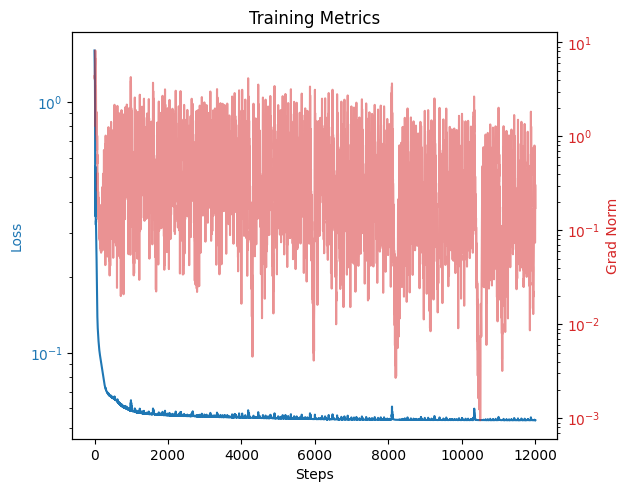

In [27]:
plot_metrics(losses, gradnorms)

## Save & Load model

In [17]:
def save_classifier(model: eqx.Module, state: eqx.nn.State, save_dir: str):
    model_path = os.path.join(save_dir, "model.eqx")
    state_path = os.path.join(save_dir, "state.eqx")

    with open(model_path, "wb") as f:
        eqx.tree_serialise_leaves(f, model)

    with open(state_path, "wb") as f:
        eqx.tree_serialise_leaves(f, state)

def load_classifier(load_dir: str) -> eqx.Module:
    model_template, state_template = eqx.nn.make_with_state(ClassifierNet)(n_channels=1, n_classes=len(label_names), bilinear=True, key=jax.random.key(0))

    model_path = os.path.join(load_dir, "model.eqx")
    state_path = os.path.join(load_dir, "state.eqx")

    with open(model_path, "rb") as f:
        model =  eqx.tree_deserialise_leaves(f, model_template)

    with open(state_path, "rb") as f:
        state =  eqx.tree_deserialise_leaves(f, state_template)

    return model, state

In [ ]:
classifier_dir = "./models/classifier"

os.makedirs(classifier_dir, exist_ok=True)
save_classifier(trained_classifier, model_state, classifier_dir)

## Evaluation

In [19]:
denoiser_dir = "./models/denoiser"

model, state = load_denoiser(denoiser_dir)

denoiser = eqx.nn.inference_mode(model)
denoiser = eqx.Partial(denoiser, state=state)

@eqx.filter_jit
def denoise(denoiser, images):
    # discard state
    deonised, _ = jax.vmap(denoiser)(images)
    return deonised

In [20]:
classifier_dir = "./models/classifier"

classifier, state = load_classifier(classifier_dir)

classifier = eqx.nn.inference_mode(classifier)
classifier = eqx.Partial(classifier, state=state)

@eqx.filter_jit
def classify(classifier, images):
    # discard state
    logits, _ = jax.vmap(classifier)(images)
    return jax.nn.softmax(logits, axis=-1)

In [43]:
def plot_images(noisy, denoised, classified, ground_truth=None, cmap = 'viridis', save_path=None):
    if ground_truth is None:
        assert noisy.shape[0] == denoised.shape[0] == classified.shape[0]
    else:
        assert noisy.shape[0] == denoised.shape[0] == classified.shape[0] == ground_truth.shape[0]
    n_images = noisy.shape[0]

    n_col = 3 if ground_truth is None else 4
    h = 3 * n_images
    w = 3 * n_col + 1

    fig, axes = plt.subplots(n_images, n_col, figsize=(w, h))

    axes[0][0].set_title("Noisy")
    axes[0][1].set_title("Denoised")
    axes[0][2].set_title("Classified")
    if ground_truth is not None:
        axes[0][3].set_title("Ground Truth")

    for idx in range(n_images):
        axes[idx][0].imshow(noisy[idx], cmap=cmap, interpolation='nearest')
        axes[idx][0].axis('off')

        axes[idx][1].imshow(denoised[idx], cmap=cmap, interpolation='nearest')
        axes[idx][1].axis('off')

        axes[idx][2].imshow(classified[idx], interpolation='nearest')
        axes[idx][2].axis('off')

        if ground_truth is not None:
            axes[idx][3].imshow(ground_truth[idx], interpolation='nearest')
            axes[idx][3].axis('off')

    fig.subplots_adjust(right=0.8)
    handles = [
        mpatches.Patch(color=tuple(np.array(palette[i])), label=label_names[i])
        for i in range(len(label_names))
    ]
    for idx in range(n_images):
        axes[idx][-1].legend(
            handles=handles,
            loc='upper left',
            bbox_to_anchor=(1.02, 1.0),
            borderaxespad=0.0,
            frameon=False
        )
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

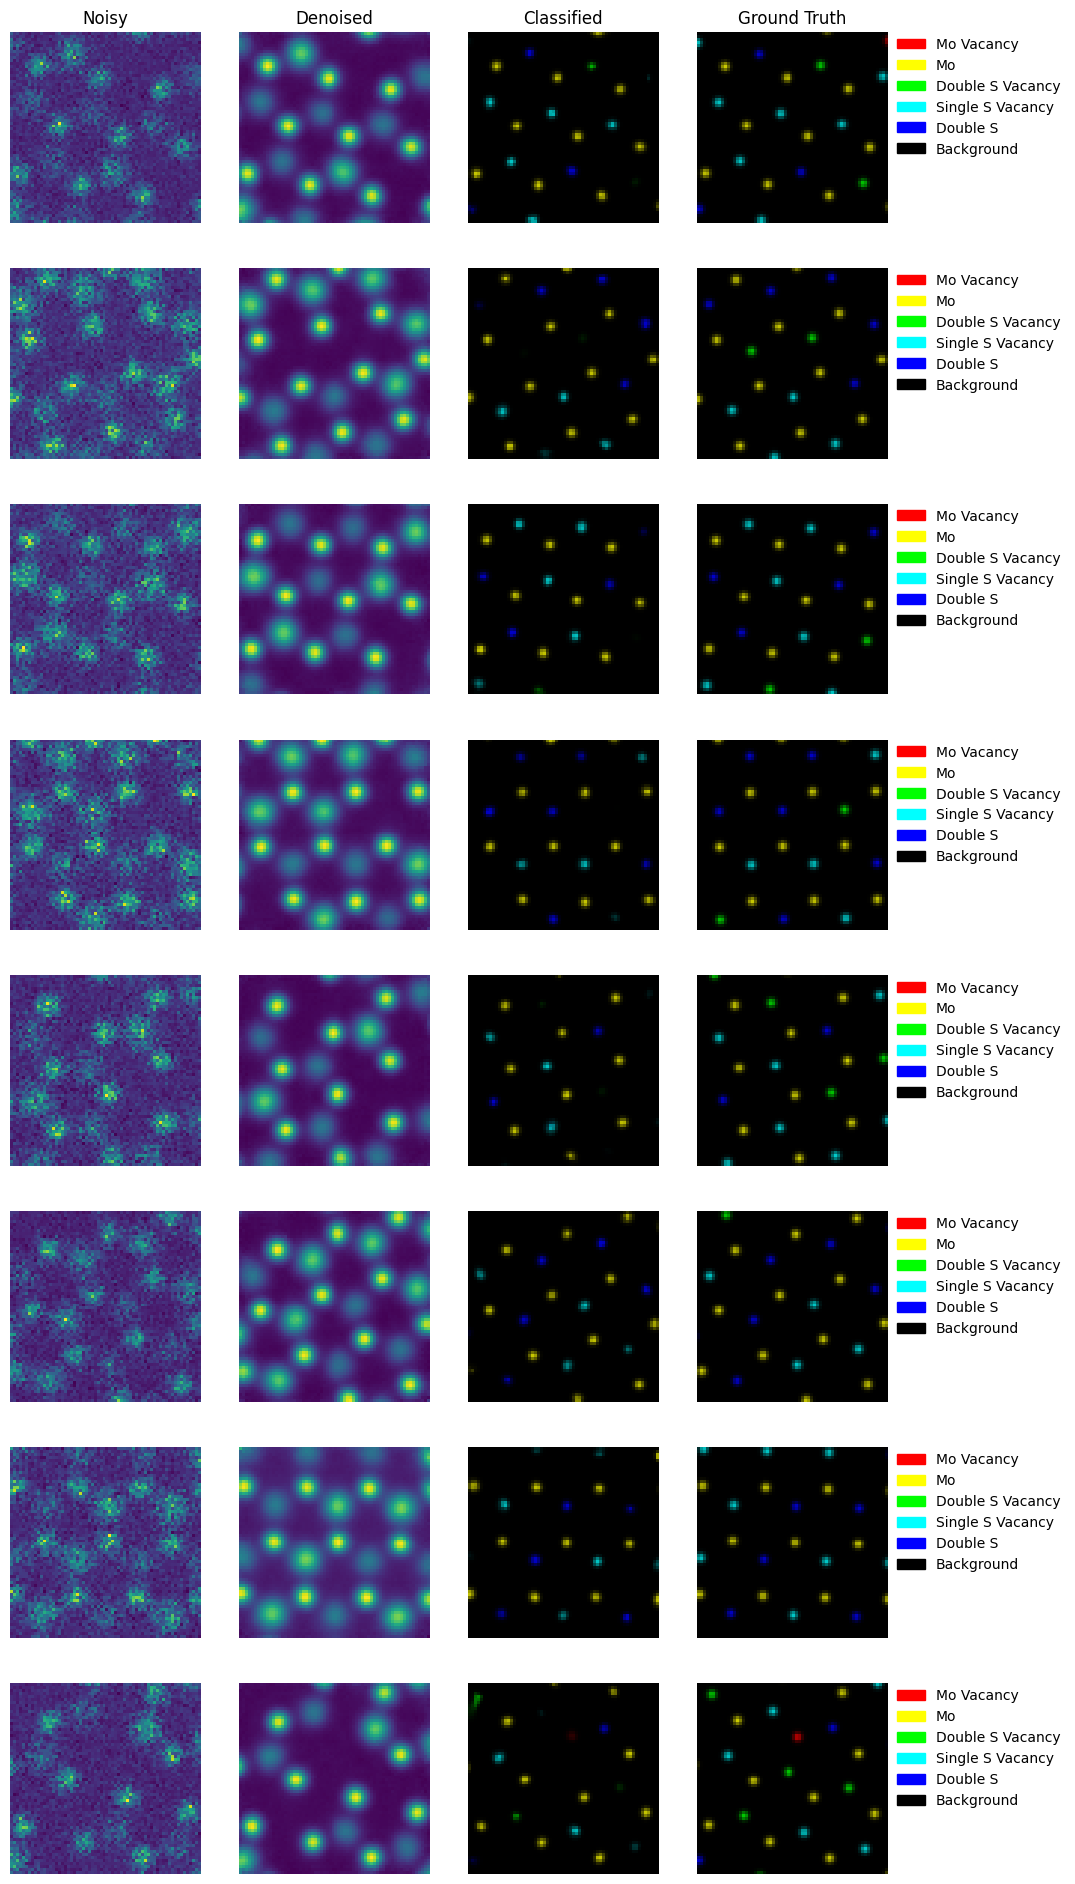

In [44]:
@jax.jit
def generate(key):
    return generate_dataset(
        key,
        width,
        height,
        pixel_size,
        lattice_vectors,
        (positions_Mo, positions_S1, positions_S2),
        position_displacement,
        Mo_feature,
        S_feature,
        dot_size,
        patch_radius
    )

@jax.jit
def generate_noised(img, key):
    return add_noise(img, num_elec_Mo, noise_mu, noise_sigma, key)

n_images = 8

img_key, noise_key, key = jax.random.split(key, 3)

subkeys = jax.random.split(img_key, n_images)
originals, labels = jax.vmap(generate)(subkeys)

subkeys = jax.random.split(noise_key, n_images)
noised = jax.vmap(generate_noised, in_axes=(0, 0))(originals, subkeys)

denoised = denoise(denoiser, noised)
classified = classify(classifier, denoised)

ground_truth_img = jax.vmap(make_img_from_soft_labels, in_axes=(0, None))(labels, palette)
classified_img = jax.vmap(make_img_from_soft_labels, in_axes=(0, None))(classified, palette)


plot_images(noised, denoised, classified_img, ground_truth_img)

## Denoising & Classification

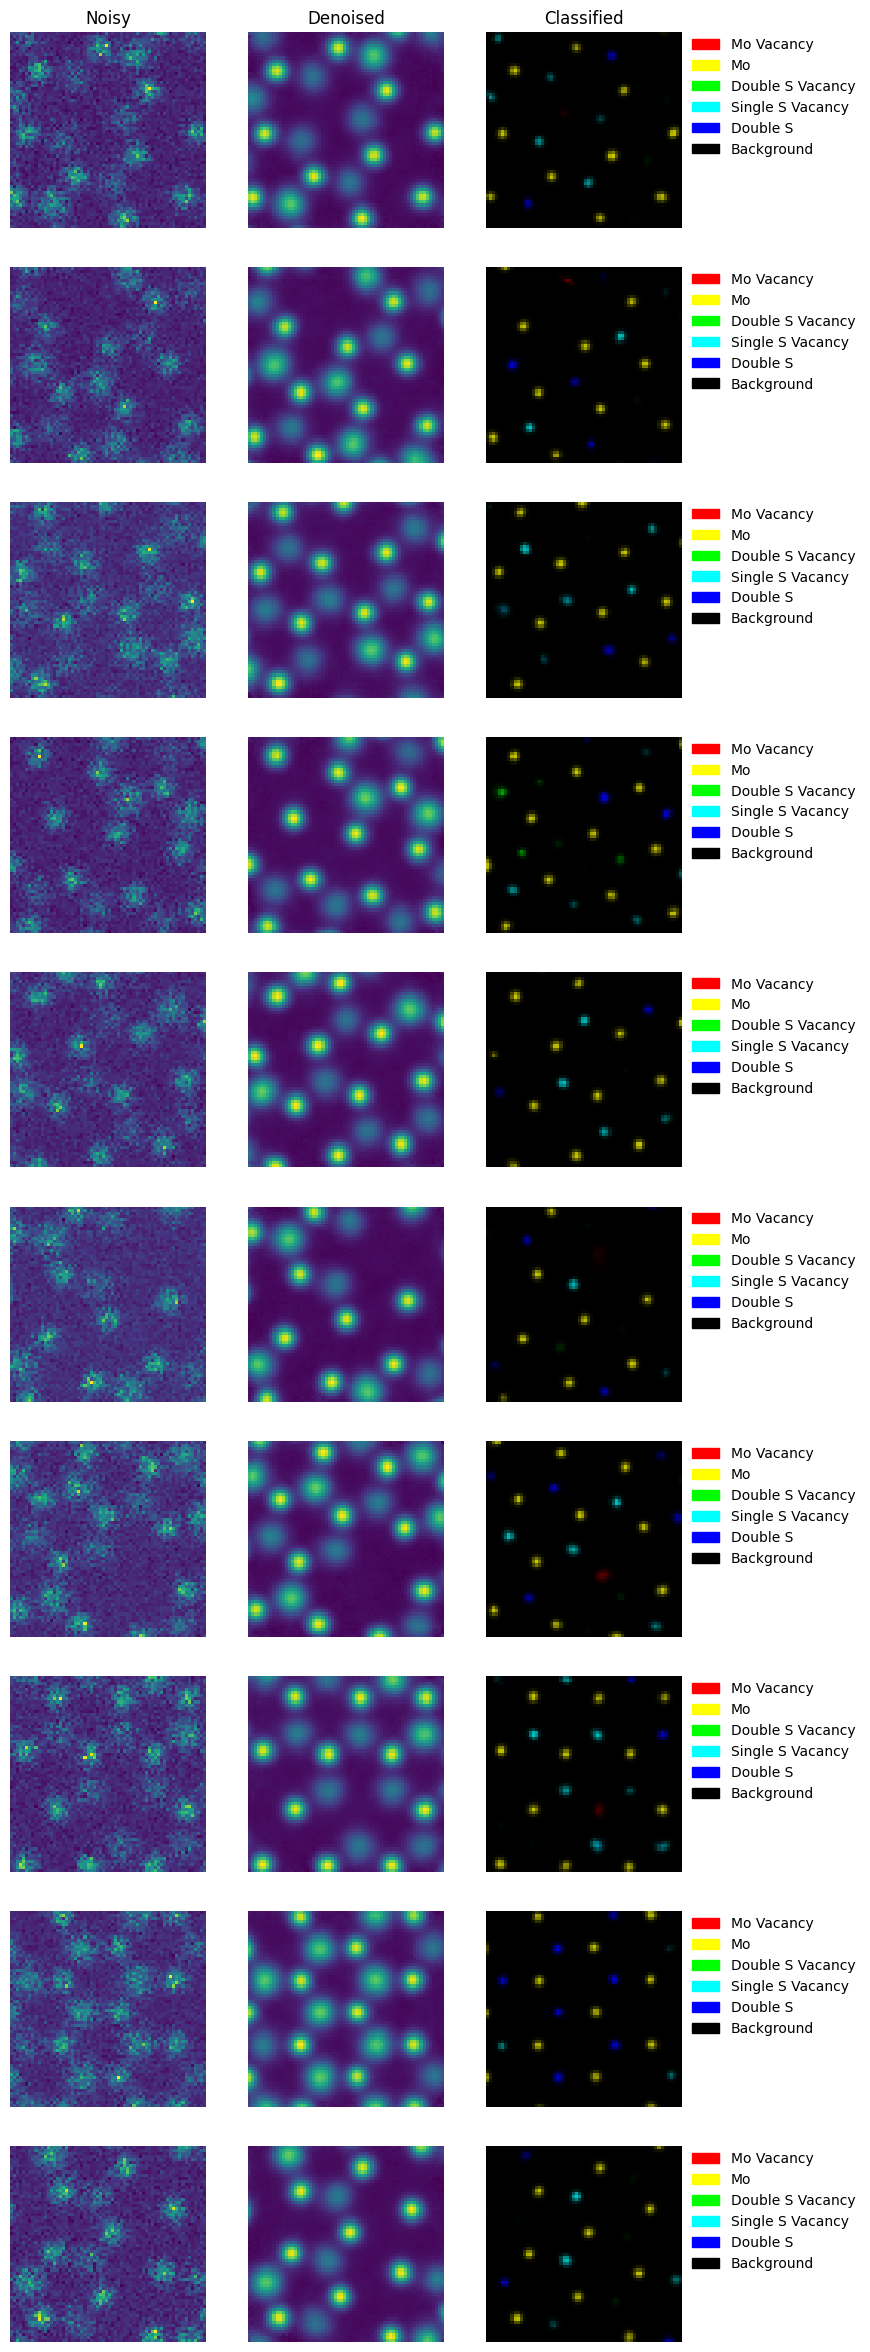

In [46]:
data_dir = "./data"
data_file_name = "TestImages_Noised.npy"
data_path = os.path.join(data_dir, data_file_name)

noisy_img = np.load(data_path)
noisy_img = np.transpose(noisy_img, (2, 0, 1))
denoised = denoise(denoiser, noisy_img)
classified = classify(classifier, denoised)
classified_img = jax.vmap(make_img_from_soft_labels, in_axes=(0, None))(classified, palette)

plot_images(noisy_img, denoised, classified_img, save_path="./classified.jpg")